<a href="https://colab.research.google.com/github/sholtodouglas/artificial_graphics/blob/main/artificial_graphics_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/deepmind/dm-haiku
!pip install wandb -q
!pip install pathy -q
!pip install natsorted -q
!pip install dall-e -q
pip install optax

SyntaxError: ignored

In [2]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

parser.add_argument('-dim', '--d_model', default=256, type=int)
parser.add_argument('-nh', '--num_heads', default=4, type=int)
parser.add_argument('-nl', '--num_layers', default=6, type=int)
parser.add_argument('-sl', '--sequence_length', default=128, type=int)
parser.add_argument('-dr', '--dropout_rate', type=float, default=0.1)
parser.add_argument('-cl', '--grad_clip_value', type=float, default=0.25)


### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset train
--test_dataset test
-c
-s DRIVE
--bucket_name iowa_bucket_lfp
'''.split())



In [3]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/artificial_graphics')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/artificial_graphics' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to artificial_graphics
os.chdir(WORKING_PATH)
import lib

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/artificial_graphics')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path '/content/artificial_graphics' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading data from Google Drive
Storage path: /content/drive/My Drive/artificial_graphics


In [4]:
if args.colab:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  raise NotImplementedError

DEVICES = jax.devices()
NUM_DEVICS = len(DEVICES)

In [6]:
# !git pull
# from importlib import reload
# reload(lib.data)

In [7]:
  
import io

import jax
import requests
import PIL
from PIL import ImageOps

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap
from jax import random

from lib.dall_e_jax import get_encoder, get_decoder, map_pixels, unmap_pixels, download_image

import matplotlib.pyplot as plt



target_image_size = 256


jax_enc_fn, jax_enc_params = get_encoder(str(STORAGE_PATH/'saved_models/') + "/encoder.pkl")
jax_dec_fn, jax_dec_params = get_decoder(str(STORAGE_PATH/'saved_models/') + "/decoder.pkl")

In [8]:



@jit
def preprocess_batch(b: dict, logit_laplace_eps = 0.1) -> dict:
  imgs = b['img']/255.0
  b['img'] = jnp.transpose(imgs, axes = [0, 3, 1, 2])
  b['img'] = (1 - 2 * logit_laplace_eps) * b['img'] + logit_laplace_eps
  return b




In [293]:
import tensorflow_datasets as tfds

train_dl = lib.data.dataloader(TRAIN_DATA_PATHS[0], batch_size = 4) # to make this distributed, pass num devices so we get an 8 ways batch - and then pmap it
train_dataset = iter(tfds.as_numpy(train_dl.dataset))


In [294]:
b = next(train_dataset)
b = jax.device_put(b, DEVICES[1])
b = preprocess_batch(b)

In [274]:
z_logits = jax_enc_fn(jax_enc_params, b['img'])
z = jnp.argmax(z_logits, axis=1)
z = jnp.transpose(jax.nn.one_hot(z, num_classes=8192), (0, 3, 1, 2))

In [295]:
# Clearly we want to precompute - ugh. 

b.keys()

dict_keys(['img', 'in', 'out'])

In [11]:
from typing import NamedTuple

from packaging import version
import tensorflow as tf
import tensorflow_datasets as tfds


class LanguageDataset(NamedTuple):
  records: tf.data.Dataset
  vocab_size: int


  def check_tfds_version():
    tfds_version = version.parse(tfds.version.__version__)
    maximum = version.parse('4.2.0')
    if tfds_version >= maximum:
      raise ValueError(f'tensorflow_datasets < {maximum} is required, you '
                      f'have {tfds_version}. You can downgrade using:\n\n'
                      '    pip install "tensorflow-datasets==4.1.0"')


  def load(batch_size: int, sequence_length: int):
    """Load LM1B dataset, returning it and vocab_size."""
    ds, ds_info = tfds.load(
        'lm1b/subwords32k',
        split=tfds.Split.TRAIN,
        shuffle_files=True,
        with_info=True)

    crop_size = sequence_length + 1
    ds = ds.repeat()
    # Convert the dataset to constant-size int32 tensors.
    ds = ds.map(lambda d: tf.cast(d['text'], tf.int32))
    ds = ds.map(lambda t: _crop_or_pad(t, crop_size, pad_token=0))
    ds = ds.shuffle(batch_size * 10)
    # Create the language modeling observation/target pairs and batch them up.
    ds = ds.map(lambda t: dict(obs=t[:-1], target=t[1:]))
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    ds = iter(tfds.as_numpy(ds))
    return LanguageDataset(ds, ds_info.features['text'].encoder.vocab_size)


  # TODO(tycai): Do a split-to-crop instead so we don't throw away data.
  def _crop_or_pad(value, size, pad_token):
    """Either crop or pad value to be of size size."""
    val_size = tf.size(value)
    pad = lambda: tf.pad(  # pylint: disable=g-long-lambda
        value, [[0, size - val_size]],
        'CONSTANT',
        constant_values=pad_token)
    return tf.cond(val_size < size, pad, lambda: value[:size])

In [12]:
# Copyright 2020 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Train a transformer for language modeling on LM1B.
This example serves to demonstrate:
  - A clean Haiku transformer implementation.
  - An example minimal training loop around it.
We have not tuned the hyperparameters for LM1B at all.
Note: Run with --alsologtostderr to see outputs.
"""

import functools
import os
import pickle
import time
from typing import Any, Mapping

from absl import app
from absl import flags
from absl import logging
import haiku as hk
from lib.model import Transformer
import jax
import jax.numpy as jnp
import numpy as np
import optax


checkpoint_dir = '/tmp/haiku-lm1b'

LOG_EVERY = 50
MAX_STEPS = 10**6


def build_forward_fn(vocab_size: int, d_model: int, num_heads: int,
                     num_layers: int, dropout_rate: float):
  """Create the model's forward pass."""

  def forward_fn(data: Mapping[str, jnp.ndarray],
                 is_training: bool = True) -> jnp.ndarray:
    """Forward pass."""
    tokens = data['obs']
    input_mask = jnp.greater(tokens, 0)
    seq_length = tokens.shape[1]

    # Embed the input tokens and positions.
    embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
    token_embedding_map = hk.Embed(vocab_size, d_model, w_init=embed_init)
    token_embs = token_embedding_map(tokens)
    positional_embeddings = hk.get_parameter(
        'pos_embs', [seq_length, d_model], init=embed_init)
    input_embeddings = token_embs + positional_embeddings

    # Run the transformer over the inputs.
    transformer = Transformer(
        num_heads=num_heads, num_layers=num_layers, dropout_rate=dropout_rate)
    output_embeddings = transformer(input_embeddings, input_mask, is_training)

    # Reverse the embeddings (untied).
    return hk.Linear(vocab_size)(output_embeddings)

  return forward_fn


def lm_loss_fn(forward_fn,
               vocab_size: int,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
  """Compute the loss on data wrt params."""
  logits = forward_fn(params, rng, data, is_training)
  targets = jax.nn.one_hot(data['target'], vocab_size)
  assert logits.shape == targets.shape

  mask = jnp.greater(data['obs'], 0)
  loss = -jnp.sum(targets * jax.nn.log_softmax(logits), axis=-1)
  loss = jnp.sum(loss * mask) / jnp.sum(mask)

  return loss


class Updater:
  """A stateless abstraction around an init_fn/update_fn pair.
  This extracts some common boilerplate from the training loop.
  """

  def __init__(self, net_init, loss_fn,
               optimizer: optax.GradientTransformation):
    self._net_init = net_init
    self._loss_fn = loss_fn
    self._opt = optimizer

  @functools.partial(jax.jit, static_argnums=0)
  def init(self, master_rng, data):
    """Initializes state of the updater."""
    out_rng, init_rng = jax.random.split(master_rng)
    params = self._net_init(init_rng, data)
    opt_state = self._opt.init(params)
    out = dict(
        step=np.array(0),
        rng=out_rng,
        opt_state=opt_state,
        params=params,
    )
    return out

  @functools.partial(jax.jit, static_argnums=0)
  def update(self, state: Mapping[str, Any], data: Mapping[str, jnp.ndarray]):
    """Updates the state using some data and returns metrics."""
    rng, new_rng = jax.random.split(state['rng'])
    params = state['params']
    loss, g = jax.value_and_grad(self._loss_fn)(params, rng, data)

    updates, opt_state = self._opt.update(g, state['opt_state'])
    params = optax.apply_updates(params, updates)

    new_state = {
        'step': state['step'] + 1,
        'rng': new_rng,
        'opt_state': opt_state,
        'params': params,
    }

    metrics = {
        'step': state['step'],
        'loss': loss,
    }
    return new_state, metrics


class CheckpointingUpdater:
  """A didactic checkpointing wrapper around an Updater.
  A more mature checkpointing implementation might:
    - Use np.savez() to store the core data instead of pickle.
    - Not block JAX async dispatch.
    - Automatically garbage collect old checkpoints.
  """

  def __init__(self,
               inner: Updater,
               checkpoint_dir: str,
               checkpoint_every_n: int = 10000):
    self._inner = inner
    self._checkpoint_dir = checkpoint_dir
    self._checkpoint_every_n = checkpoint_every_n

  def _checkpoint_paths(self):
    return [p for p in os.listdir(self._checkpoint_dir) if 'checkpoint_' in p]

  def init(self, rng, data):
    """Initialize experiment state."""
    if not os.path.exists(self._checkpoint_dir) or not self._checkpoint_paths():
      os.makedirs(self._checkpoint_dir, exist_ok=True)
      return self._inner.init(rng, data)
    else:
      checkpoint = os.path.join(self._checkpoint_dir,
                                self._checkpoint_paths()[-1])
      logging.info('Loading checkpoint from %s', checkpoint)
      with open(checkpoint, 'rb') as f:
        state = pickle.load(f)
      return state

  def update(self, state, data):
    """Update experiment state."""
    # NOTE: This blocks until `state` is computed. If you want to use JAX async
    # dispatch, maintain state['step'] as a NumPy scalar instead of a JAX array.
    # Context: https://jax.readthedocs.io/en/latest/async_dispatch.html
    step = np.array(state['step'])
    if step % self._checkpoint_every_n == 0:
      path = os.path.join(self._checkpoint_dir,
                          'checkpoint_{:07d}.pkl'.format(step))
      checkpoint_state = jax.device_get(state)
      logging.info('Serializing experiment state to %s', path)
      with open(path, 'wb') as f:
        pickle.dump(checkpoint_state, f)

    state, out = self._inner.update(state, data)
    return state, out






In [ ]:
train_dataset, vocab_size = LanguageDataset.load(args.batch_size,
                                          args.sequence_length)
# Set up the model, loss, and updater.
forward_fn = build_forward_fn(vocab_size, args.d_model, args.num_heads,
                              args.num_layers, args.dropout_rate)
forward_fn = hk.transform(forward_fn)
loss_fn = functools.partial(lm_loss_fn, forward_fn.apply, vocab_size)

optimizer = optax.chain(
    optax.clip_by_global_norm(args.grad_clip_value),
    optax.adam(args.learning_rate, b1=0.9, b2=0.99))

updater = Updater(forward_fn.init, loss_fn, optimizer)
updater = CheckpointingUpdater(updater, args.checkpoint_dir)

# Initialize parameters.
logging.info('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = next(train_dataset)
state = updater.init(rng, data)

logging.info('Starting train loop...')
prev_time = time.time()
for step in range(MAX_STEPS):
  data = next(train_dataset)
  state, metrics = updater.update(state, data)
  # We use JAX runahead to mask data preprocessing and JAX dispatch overheads.
  # Using values from state/metrics too often will block the runahead and can
  # cause these overheads to become more prominent.
  if step % LOG_EVERY == 0:
    steps_per_sec = LOG_EVERY / (time.time() - prev_time)
    prev_time = time.time()
    metrics.update({'steps_per_sec': steps_per_sec})
    logging.info({k: float(v) for k, v in metrics.items()})


In [319]:
import sys
args(sys.argv)

UnrecognizedFlagError: ignored

In [323]:
# Create the dataset.


KeyboardInterrupt: ignored

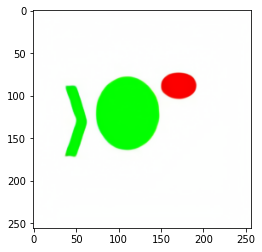

In [241]:
#@title Test recon
x = b['img'][0][jnp.newaxis]
z_logits = jax_enc_fn(jax_enc_params, x)
z = jnp.argmax(z_logits, axis=1)
z = jnp.transpose(jax.nn.one_hot(z, num_classes=8192), (0, 3, 1, 2))
B, D, H, W = z.shape
#z = jnp.reshape(jnp.repeat(jnp.reshape(z, (B, D, H*W))[:,:,::2], 2, axis = -1), (B,D,H,W))
x_stats = jax_dec_fn(jax_dec_params, z)
x_rec = unmap_pixels(jax.nn.sigmoid(x_stats[:, :3]))
x_rec = np.transpose((np.array(x_rec[0]) * 255).astype(np.uint8), (1, 2, 0))
plt.imshow(x_rec)